In [1]:
#import library
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:

df = pd.read_csv('FOOD-DATA-GROUP5.csv')
print(df.head())
print(df.info())
print(df.describe())

# Tăng chiều rộng và hiển thị đầy đủ các cột
pd.set_option('display.max_columns', None)  # Không giới hạn số lượng cột
pd.set_option('display.width', 1000)       # Tăng chiều rộng dòng hiển thị
pd.set_option('display.max_colwidth', None)  # Không giới hạn độ dài của cột văn bản

# Kiểm tra dữ liệu thiếu
print(df.isnull().sum())


   Unnamed: 0.1  Unnamed: 0                    food  Caloric Value    Fat  \
0             0           0  margarine with yoghurt             88    9.8   
1             1           1   sunflower seed butter             99    8.8   
2             2           2            hazelnut oil            120   13.6   
3             3           3       menhaden fish oil           1966  218.0   
4             4           4      cod liver fish oil            123   13.6   

   Saturated Fats  Monounsaturated Fats  Polyunsaturated Fats  Carbohydrates  \
0             1.9                   5.6                   2.0          0.073   
1             0.7                   6.2                   1.6          3.700   
2             1.0                  10.6                   1.4          0.000   
3            66.3                  58.2                  74.5          0.000   
4             3.1                   6.4                   3.1          0.000   

   Sugars  ...  Calcium  Copper   Iron  Magnesium  Manga

In [3]:

# Tách các cột số cần chuẩn hóa (nếu không được chỉ định, tự động chọn tất cả các cột số)
numeric_columns = [
    'Caloric Value', 'Fat', 'Carbohydrates', 'Sugars', 'Protein',
    'Dietary Fiber', 'Cholesterol', 'Sodium', 'Water',
    'Calcium', 'Iron', 'Magnesium', 'Manganese' , 'Selenium', 
    'Phosphorus', 'Potassium', 'Zinc' , 
]

epsilon = 1e-3  # Giá trị nhỏ để thay thế 0
df[numeric_columns] = df[numeric_columns].replace(0, epsilon) # Xử lý các giá trị bằng 0

# Chuẩn hóa bằng Min-Max Scaling
scaler = MinMaxScaler()
food_data= df[numeric_columns].copy()
food_data[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Hiển thị dữ liệu
print("Dữ liệu sau khi chuẩn hóa (Min-Max Scaling):")
print(food_data.head())

Dữ liệu sau khi chuẩn hóa (Min-Max Scaling):
   Caloric Value       Fat  Carbohydrates    Sugars   Protein  Dietary Fiber  Cholesterol    Sodium     Water   Calcium      Iron  Magnesium  Manganese  Selenium  Phosphorus  Potassium      Zinc
0       0.026379  0.044950       0.000379  0.000000  0.000664       0.000000     0.000000  0.000344  0.005346  0.003225  0.000890   0.000400   0.000000  0.000000    0.001679   0.000863  0.000295
1       0.029676  0.040363       0.019458  0.016181  0.032623       0.015342     0.000000  0.001296  0.000136  0.011750  0.023939   0.066683   0.000663  0.000022    0.081411   0.022748  0.033715
2       0.035971  0.062381       0.000000  0.000000  0.000000       0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000    0.000000   0.000000  0.000000
3       0.589328  1.000000       0.000000  0.000000  0.000000       0.000000     1.000000  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000    0.000000  

               Heart Disease Risk  Diabetes Risk  Cancer Risk  Gout Risk  Hypertension Risk
Caloric Value            0.223858       0.082910     0.492988   0.430377          -0.018759
Fat                      0.339160      -0.021959     0.759982   0.238531          -0.009827
Carbohydrates           -0.021936       0.258540    -0.049154   0.294636          -0.021936
Sugars                  -0.011811       0.777015    -0.026466  -0.020114          -0.011811
Protein                 -0.015561      -0.017389    -0.034869   0.784430          -0.015561
Dietary Fiber           -0.015670       0.047338    -0.035114   0.441018          -0.015670
Cholesterol              0.731194      -0.012893     0.318980   0.375050          -0.004858
Sodium                  -0.004794       0.000628    -0.010743  -0.011911           0.133597
Water                   -0.024043       0.091060    -0.053874   0.074056          -0.024035
Calcium                 -0.015308       0.013891    -0.034302   0.330568        

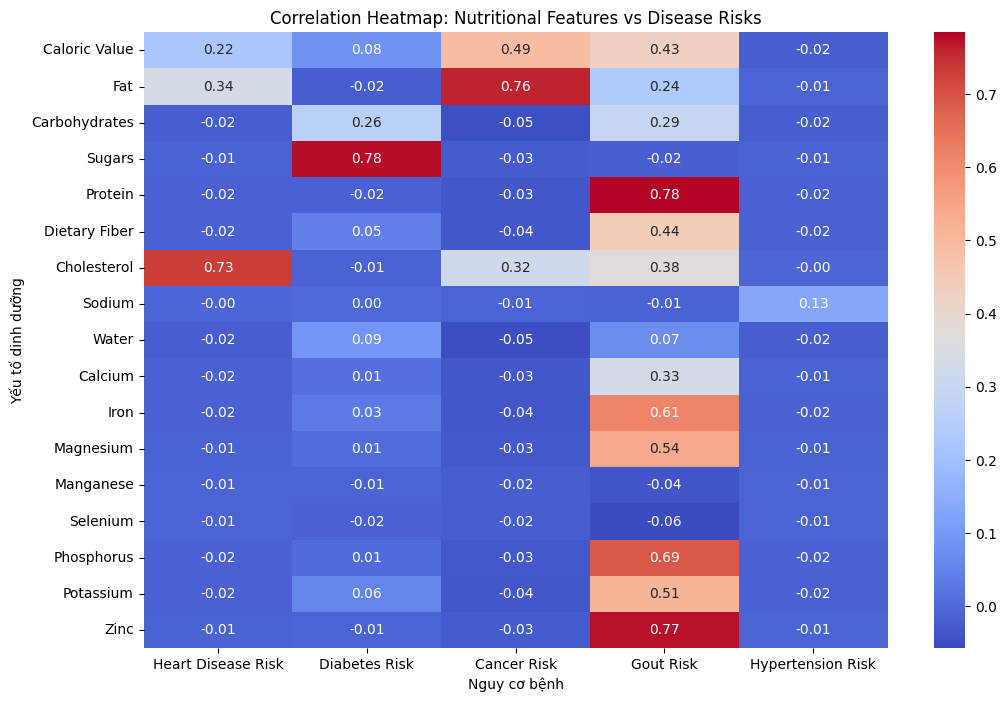

In [4]:
# Giả định các ngưỡng bệnh cho dữ liệu
# Quy đổi các ngưỡng cho dữ liệu chuẩn hóa (khoảng [0, 1])
food_data['Heart Disease Risk'] = ((food_data['Cholesterol'] > 0.66) & (food_data['Fat'] > 0.5)).astype(int) 
food_data['Diabetes Risk'] = ((food_data['Sugars'] > 0.5) & (food_data['Carbohydrates'] > 0.07)).astype(int) 
food_data['Cancer Risk'] = ((food_data['Fat'] > 0.67) & (food_data['Protein'] < 0.3)).astype(int)  
food_data['Gout Risk'] = ((food_data['Protein'] > 0.5)).astype(int)  
food_data['Hypertension Risk'] = ((food_data['Sodium'] > 0.04) & (food_data['Calcium'] < 0.02)).astype(int) 

# Chọn các cột dinh dưỡng và nguy cơ bệnh
nutritional_features = ['Caloric Value', 'Fat', 'Carbohydrates', 'Sugars', 'Protein',
                        'Dietary Fiber', 'Cholesterol', 'Sodium', 'Water',
                        'Calcium', 'Iron', 'Magnesium', 'Manganese' , 'Selenium', 
                        'Phosphorus', 'Potassium', 'Zinc']
disease_columns = ['Heart Disease Risk', 'Diabetes Risk', 'Cancer Risk', 'Gout Risk', 'Hypertension Risk']
# Lọc dữ liệu
subset = food_data[nutritional_features + disease_columns]

# Nếu có NaN, có thể loại bỏ các dòng chứa NaN hoặc điền giá trị thiếu
subset_cleaned = subset.dropna()  # Loại bỏ các dòng chứa NaN

# Tính ma trận tương quan
correlation_matrix = subset_cleaned.corr().loc[nutritional_features, disease_columns]
print(correlation_matrix)

# Vẽ heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Nutritional Features vs Disease Risks')
plt.xlabel('Nguy cơ bệnh')
plt.ylabel('Yếu tố dinh dưỡng')
plt.show()


In [5]:

# Chọn mục tiêu và yếu tố dự đoán
X = food_data[nutritional_features]
y = food_data['Heart Disease Risk']  # bệnh tim 

# Chọn 5 yếu tố quan trọng nhất
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

# Xem các yếu tố quan trọng
important_features = selector.get_support(indices=True)
print("Các yếu tố quan trọng nhất ảnh hưởng tới bệnh tim:", [nutritional_features[i] for i in important_features])

Các yếu tố quan trọng nhất ảnh hưởng tới bệnh tim: ['Caloric Value', 'Fat', 'Carbohydrates', 'Cholesterol', 'Water']


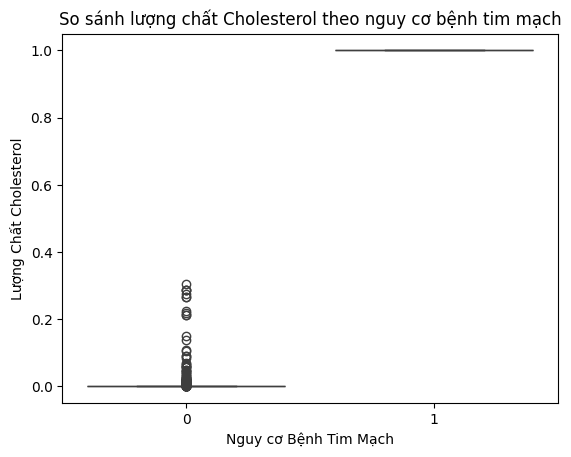

In [6]:
# Biểu đồ boxplot so sánh lượng chất béo theo nguy cơ bệnh tim mạch
sns.boxplot(x=food_data['Heart Disease Risk'], y=food_data['Cholesterol'])
plt.title('So sánh lượng chất Cholesterol theo nguy cơ bệnh tim mạch')
plt.xlabel('Nguy cơ Bệnh Tim Mạch')
plt.ylabel('Lượng Chất Cholesterol')
plt.show()


In [ ]:

# Xác định biến mục tiêu và biến dự đoán
target_Heart_Disease = 'Heart Disease Risk' # Biến mục tiêu (target_Heart_Disease): Một trong các cột nguy cơ bệnh
features_Heart_Disease = ['Fat', 'Caloric Value', 'Cholesterol', 'Carbohydrates', 'Water']  # Biến dự đoán Các cột chứa thông tin dinh dưỡng 

X_heart = food_data[features_Heart_Disease]
print("Tập kiểm thử X_heart : \n", X_heart)
y_heart = food_data[target_Heart_Disease]
print("Tập kiểm thử y_heart : \n", y_heart)

Tập kiểm thử X_heart : 
           Fat  Caloric Value  Cholesterol  Carbohydrates     Water
0    0.044950       0.026379     0.000000       0.000379  0.005346
1    0.040363       0.029676     0.000000       0.019458  0.000136
2    0.062381       0.035971     0.000000       0.000000  0.000000
3    1.000000       0.589328     1.000000       0.000000  0.000000
4    0.062381       0.036870     0.068233       0.000000  0.000000
..        ...            ...          ...            ...       ...
949  0.015592       0.069244     0.000000       0.240396  0.006992
950  0.011005       0.037170     0.000000       0.023667  0.000000
951  0.003665       0.039268     0.000000       0.169380  0.001918
952  0.027060       0.073441     0.000000       0.243026  0.003564
953  0.001372       0.032374     0.000000       0.129401  0.001233

[954 rows x 5 columns]
Tập kiểm thử y_heart : 
 0      0
1      0
2      0
3      1
4      0
      ..
949    0
950    0
951    0
952    0
953    0
Name: Heart Disease Ris

In [8]:

# Chia nhỏ mô hình cho tập
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(X_heart, y_heart, test_size=0.4, random_state=42)  
print("Kích thước tập huấn luyện:", X_train_heart.shape)
print("Kích thước tập kiểm thử:", X_test_heart.shape)

Kích thước tập huấn luyện: (572, 5)
Kích thước tập kiểm thử: (382, 5)


In [9]:
# Khởi tạo mô hình
decision_tree = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Đào tạo mô hình
decision_tree.fit(X_train_heart, y_train_heart)
random_forest.fit(X_train_heart, y_train_heart)

print("Mô hình Decision Trees và Random Forests đã được huấn luyện.")

Mô hình Decision Trees và Random Forests đã được huấn luyện.


In [10]:
# Dự đoán trên tập kiểm thử
y_pred_dt = decision_tree.predict(X_test_heart)
y_pred_rf = random_forest.predict(X_test_heart)

# Tính các chỉ số đánh giá (tránh lỗi bằng zero_division)
accuracy_dt = accuracy_score(y_test_heart, y_pred_dt)
sensitivity_dt = recall_score(y_test_heart, y_pred_dt, pos_label=1, zero_division=0)
specificity_dt = recall_score(y_test_heart, y_pred_dt, pos_label=0, zero_division=0)

accuracy_rf = accuracy_score(y_test_heart, y_pred_rf)
sensitivity_rf = recall_score(y_test_heart, y_pred_rf, pos_label=1, zero_division=0)
specificity_rf = recall_score(y_test_heart, y_pred_rf, pos_label=0, zero_division=0)

# In kết quả
print("Đánh giá mô hình Decision Trees:")
print(f"Độ chính xác: {accuracy_dt}")
print(f"Độ nhạy: {sensitivity_dt}")
print(f"Độ đặc hiệu: {specificity_dt}")

print("\nĐánh giá mô hình Random Forests:")
print(f"Độ chính xác: {accuracy_rf}")
print(f"Độ nhạy: {sensitivity_rf}")
print(f"Độ đặc hiệu: {specificity_rf}")

# Kiểm tra nhãn và chỉ định đầy đủ nhãn trong ma trận nhầm lẫn
unique_labels = sorted(set(y_test_heart) | set(y_pred_dt) | set(y_pred_rf))  # Tập hợp tất cả các nhãn


Đánh giá mô hình Decision Trees:
Độ chính xác: 0.9973821989528796
Độ nhạy: 0.0
Độ đặc hiệu: 0.9973821989528796

Đánh giá mô hình Random Forests:
Độ chính xác: 1.0
Độ nhạy: 0.0
Độ đặc hiệu: 1.0


In [11]:

# Tính toán độ quan trọng của các yếu tố
# Tính toán độ quan trọng của các thuộc tính
importances = random_forest.feature_importances_  
# Sử dụng các tên cột từ tập dữ liệu huấn luyện
feature_importance = pd.DataFrame({'Feature': X_train_heart.columns, 'Importance': importances}) 
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Hiển thị kết quả dưới dạng bảng
print("Độ quan trọng của các yếu tố dinh dưỡng và hành vi:")
print(feature_importance)



Độ quan trọng của các yếu tố dinh dưỡng và hành vi:
         Feature  Importance
2    Cholesterol    0.493354
1  Caloric Value    0.433290
0            Fat    0.068956
3  Carbohydrates    0.003673
4          Water    0.000727


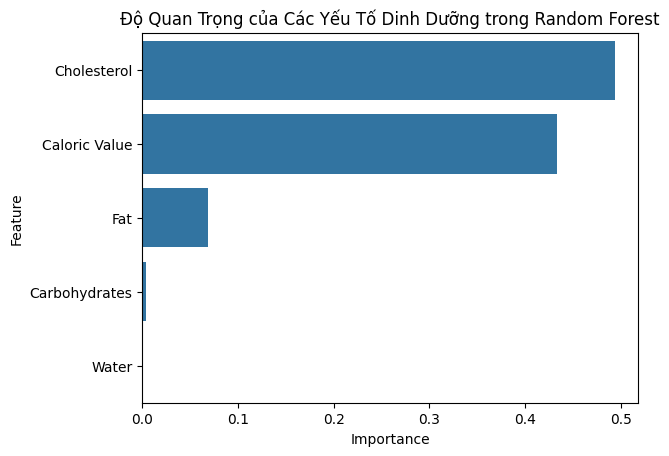

In [12]:
# Vẽ biểu đồ độ quan trọng
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Độ Quan Trọng của Các Yếu Tố Dinh Dưỡng trong Random Forest')
plt.show()